<a href="https://colab.research.google.com/github/sokanaid/CourseProject2022BiologicalMath/blob/main/find_plateau_threshold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подбор порога остановы на плато

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/sim_tables

Mounted at /content/drive/
/content/drive/MyDrive/sim_tables


## Чтение данных

In [3]:
def read_csv_file(directory_path, name):
  file_path = os.path.join(directory_path, name + ".csv")
  # print("read file ", file_path)
  return pd.read_csv(file_path)

In [4]:
def read_description(directory_path, file_name = "description.txt", parse_params = False):
  file_path = os.path.join(directory_path, file_name)
  # print("read description from file  ", file_path)
  with open(file_path, 'r') as file:
    if not parse_params:
      return file.read()
    result = {}
    for line in file:
      name, value = line.split('=')
      value = value.strip(' \t\n\r')
      if value == 'TRUE':
        value = True
      elif value == 'FALSE':
        value = False
      else:
        try:
          value = float(value)
        except:
          try:
            value = int(value)
          except:
            ...
      result[name] = value
    return result

In [5]:
def read_files(directory_path):
  data = {}
  # строковое описание параметров
  data["description_str"] = read_description(directory_path)
  # описание параметров в виде словаря
  data["params"] =  read_description(directory_path, parse_params = True)
  # численность популяции
  data["population"] = read_csv_file(directory_path, "population")
  data["population"].drop(data["population"].tail(1).index, inplace=True)
  data["population"].rename(columns={"Unnamed: 0": 'epochs'}, inplace=True)
  # результаты последовательных сглаживаний численности популяции
  name = "exp_pop10"
  data[name] = read_csv_file(directory_path, name)
  data[name].rename(columns={"Unnamed: 0": 'epochs'}, inplace=True)
  return data

In [6]:
# читаем все результаты симуляций из папок 
def read_all_simulations(directories_paths):
  data = []
  for directory_path in directories_paths:
    for simulation_diractory_name in os.listdir(directory_path):
      simulation_diractory_path = os.path.join(directory_path, simulation_diractory_name)
      if os.path.isdir(simulation_diractory_path):
        result = read_files(simulation_diractory_path)
        # только симуляции без поиска плато и принудительной остановки по достижению предела времени исполнения
        if not result["params"]['auto_stop_at_plateau'] and not result["params"]['realtime_limit_reached']:
          data.append(result)
  return data

## Построение графиков

In [7]:
def print_all_in_one_frame(Data, x="time", y = "population", limit = 25000):
  limit = min(limit, len(Data[0][y]))
  if y== "exp_pop":
    type_d = "exp_pop"
  if 'exp' in y and y!="exp_pop":
    type_d = "exp_pop2"
  else:
    type_d = "pop"
  fig = plt.figure(figsize=(40, 5), dpi=80)
  plt.axis('off')
  plt.title("Simulations" )
  #fig.tight_layout(pad=6.0,  h_pad=3, w_pad=3)
  fig.patch.set_visible(False)
  axes = fig.subplots(nrows=1, ncols=1)
  for i, data_ in enumerate(Data):
    axes.plot(data_[y][x][:limit], data_[y][type_d][:limit], label="#"+str(i))
    axes.set_xlabel(x)
    axes.set_ylabel(y)
  axes.legend(loc="lower right")


## Работа с симуляциями


In [98]:
directories = list(set([
                "/content/drive/MyDrive/sim_tables/find_plateau_threshold_ks", 
                "/content/drive/MyDrive/sim_tables/find_plateau_threshold_ks2",
                "/content/drive/MyDrive/sim_tables/find_plateau_threshold_ks3",
                "/content/drive/MyDrive/sim_tables/find_plateau_threshold_ks4",
                "/content/drive/MyDrive/sim_tables/find_plateau_threshold_ks5",
                "/content/drive/MyDrive/sim_tables/find_plateau_threshold_ks6",
                "/content/drive/MyDrive/sim_tables/find_plateau_threshold_ks7",
                "/content/drive/MyDrive/sim_tables/kurkin_b=02_d=002"
               ]))
data = read_all_simulations(directories)

In [99]:
data[0]['params']

{'dd': 0.75,
 'death_r': 100.0,
 'epochs_count': 25000.0,
 'plateau_threshold': 8.0,
 'area_length_x': 6000.0,
 'initial_pop': 1.0,
 'auto_stop_at_plateau': False,
 'b': 1.0,
 'sd_b': 0.9,
 'sd_d': 0.7,
 'found_plateau': False,
 'realtime_limit_reached': False}

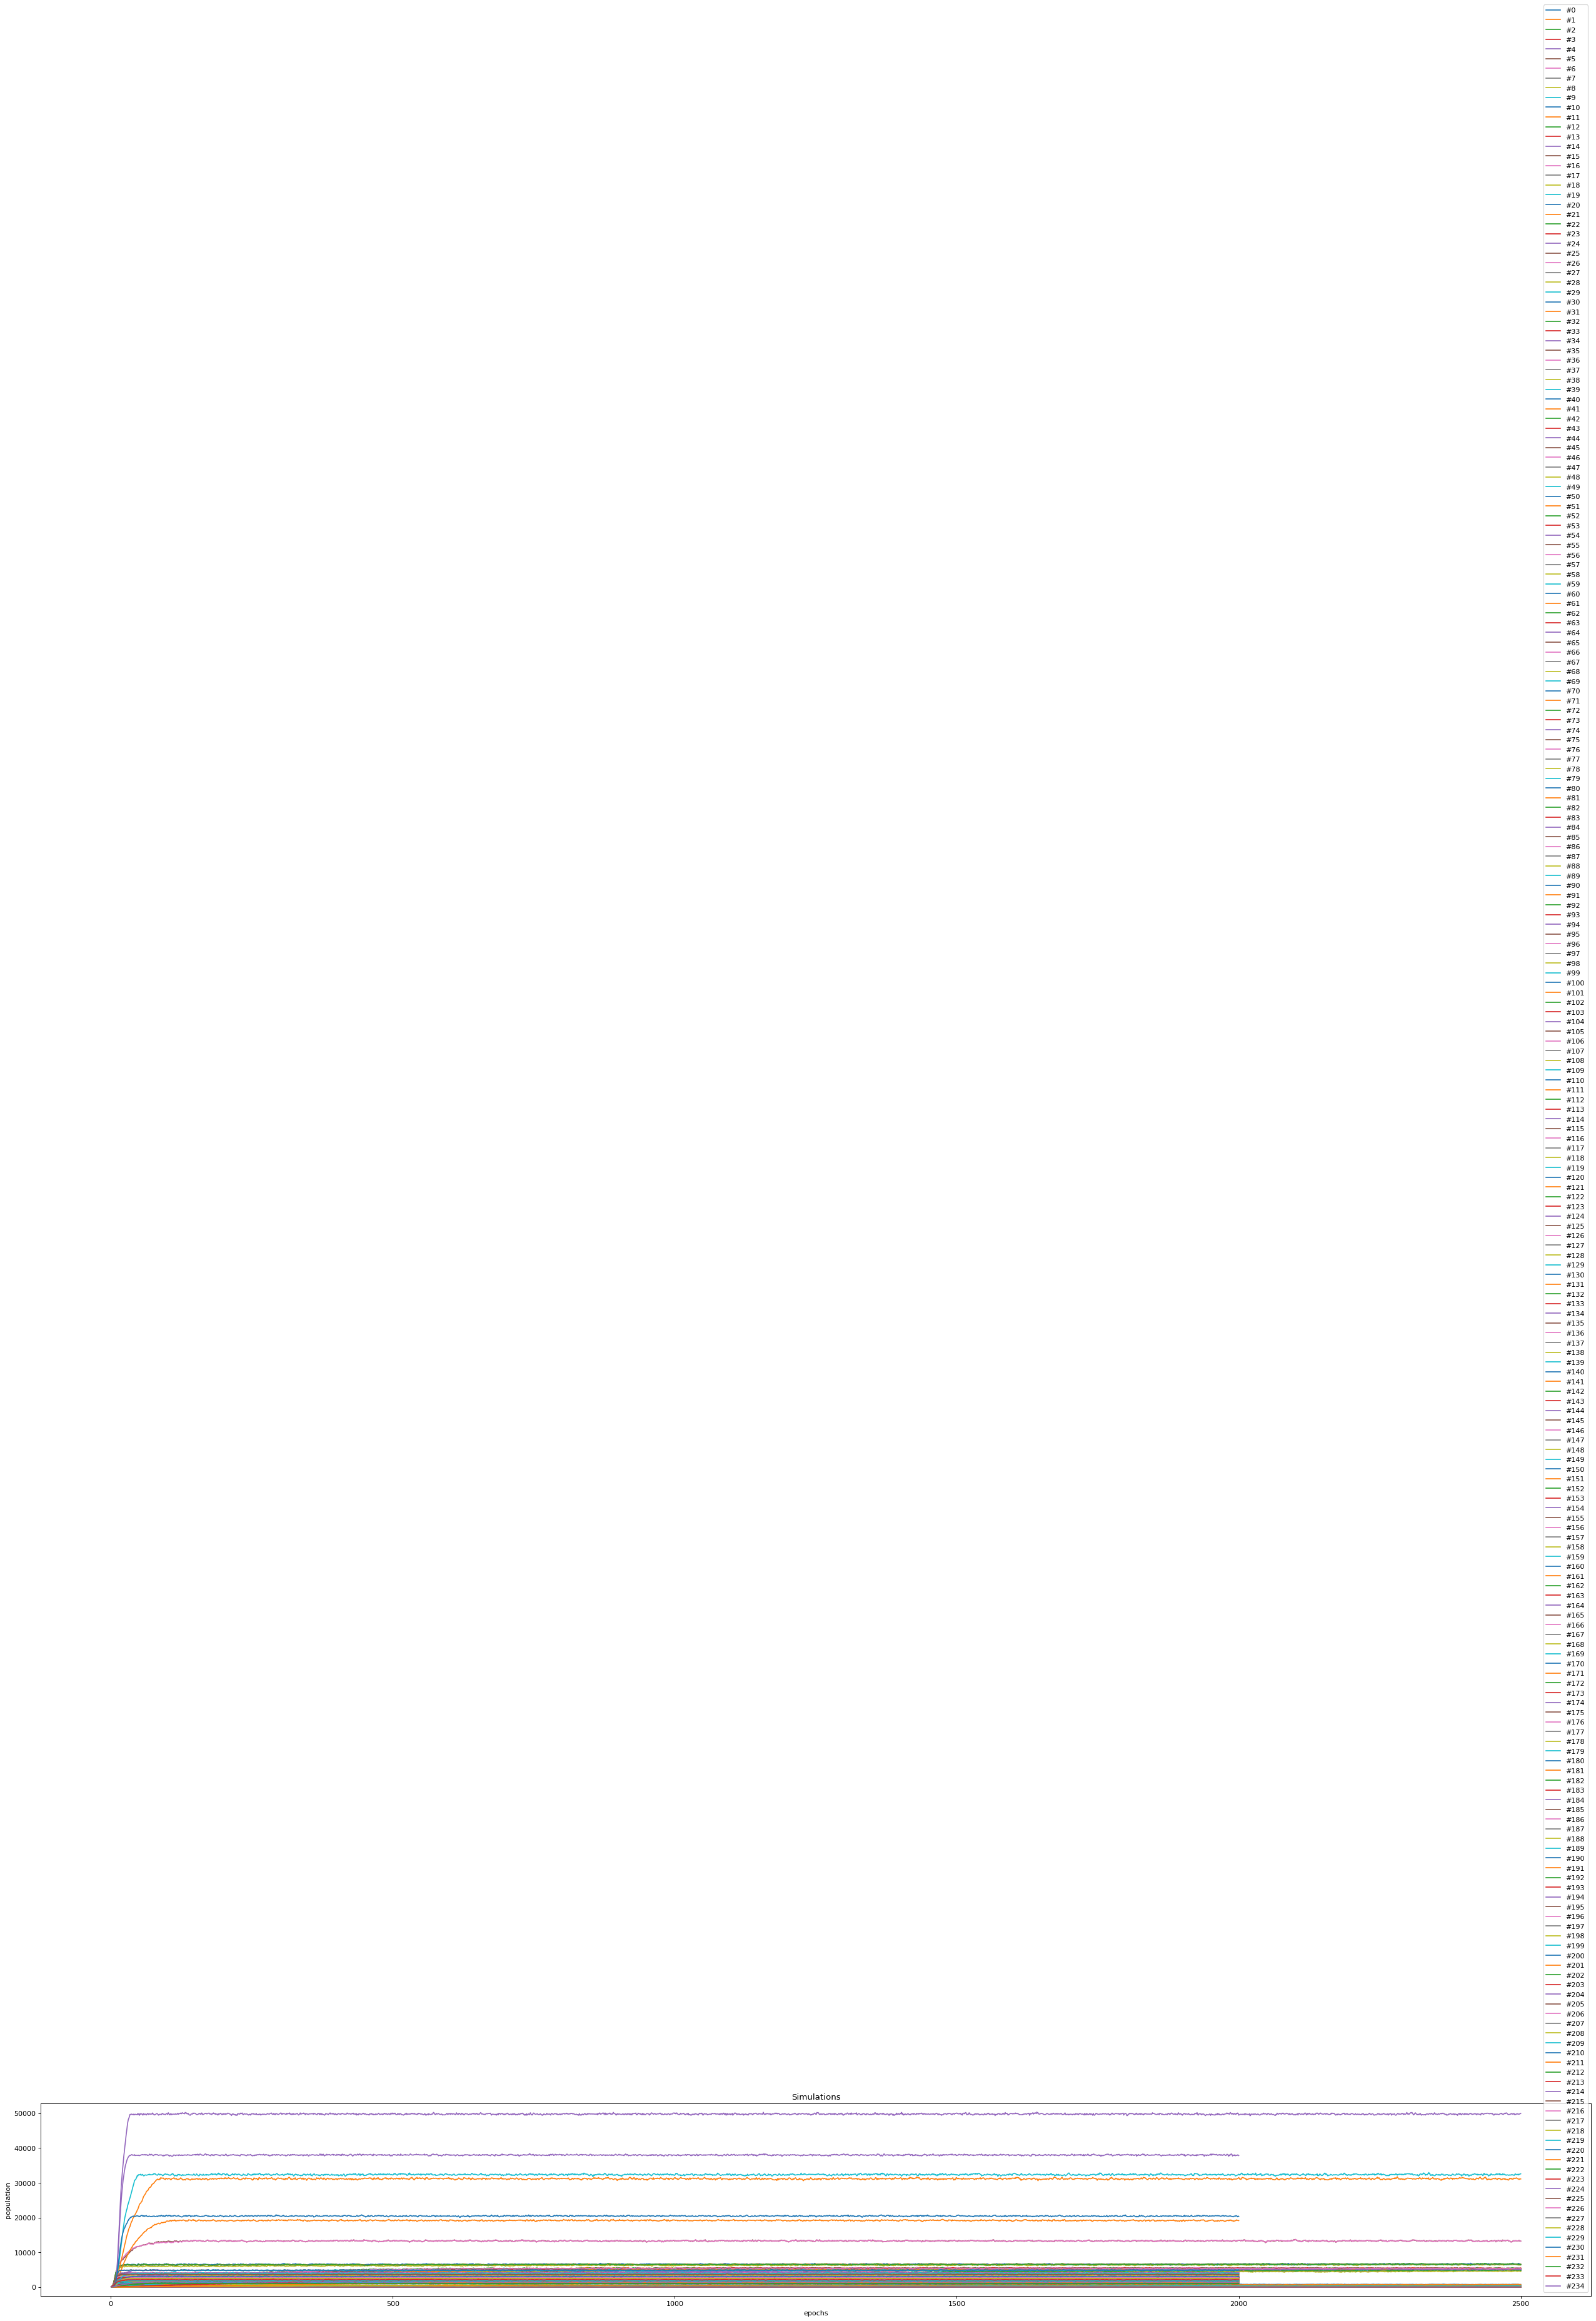

In [100]:
# построим все графики 
print_all_in_one_frame([data_ for data_ in data if not data_["params"]['auto_stop_at_plateau'] and not data_["params"]['realtime_limit_reached']] ,x = "epochs", limit = 2500)

In [101]:
data[0]["exp_pop10"]

,epochs,time,exp_pop2
0,1,0.00,1.00
1,2,1.59,1.06
2,3,1.94,1.16
3,4,2.35,1.39
4,5,3.17,1.68
...,...,...,...
24996,24997,"16,487.03",3.45
24997,24998,"16,487.44",3.58
24998,24999,"16,487.51",3.68
24999,25000,"16,487.84",3.75


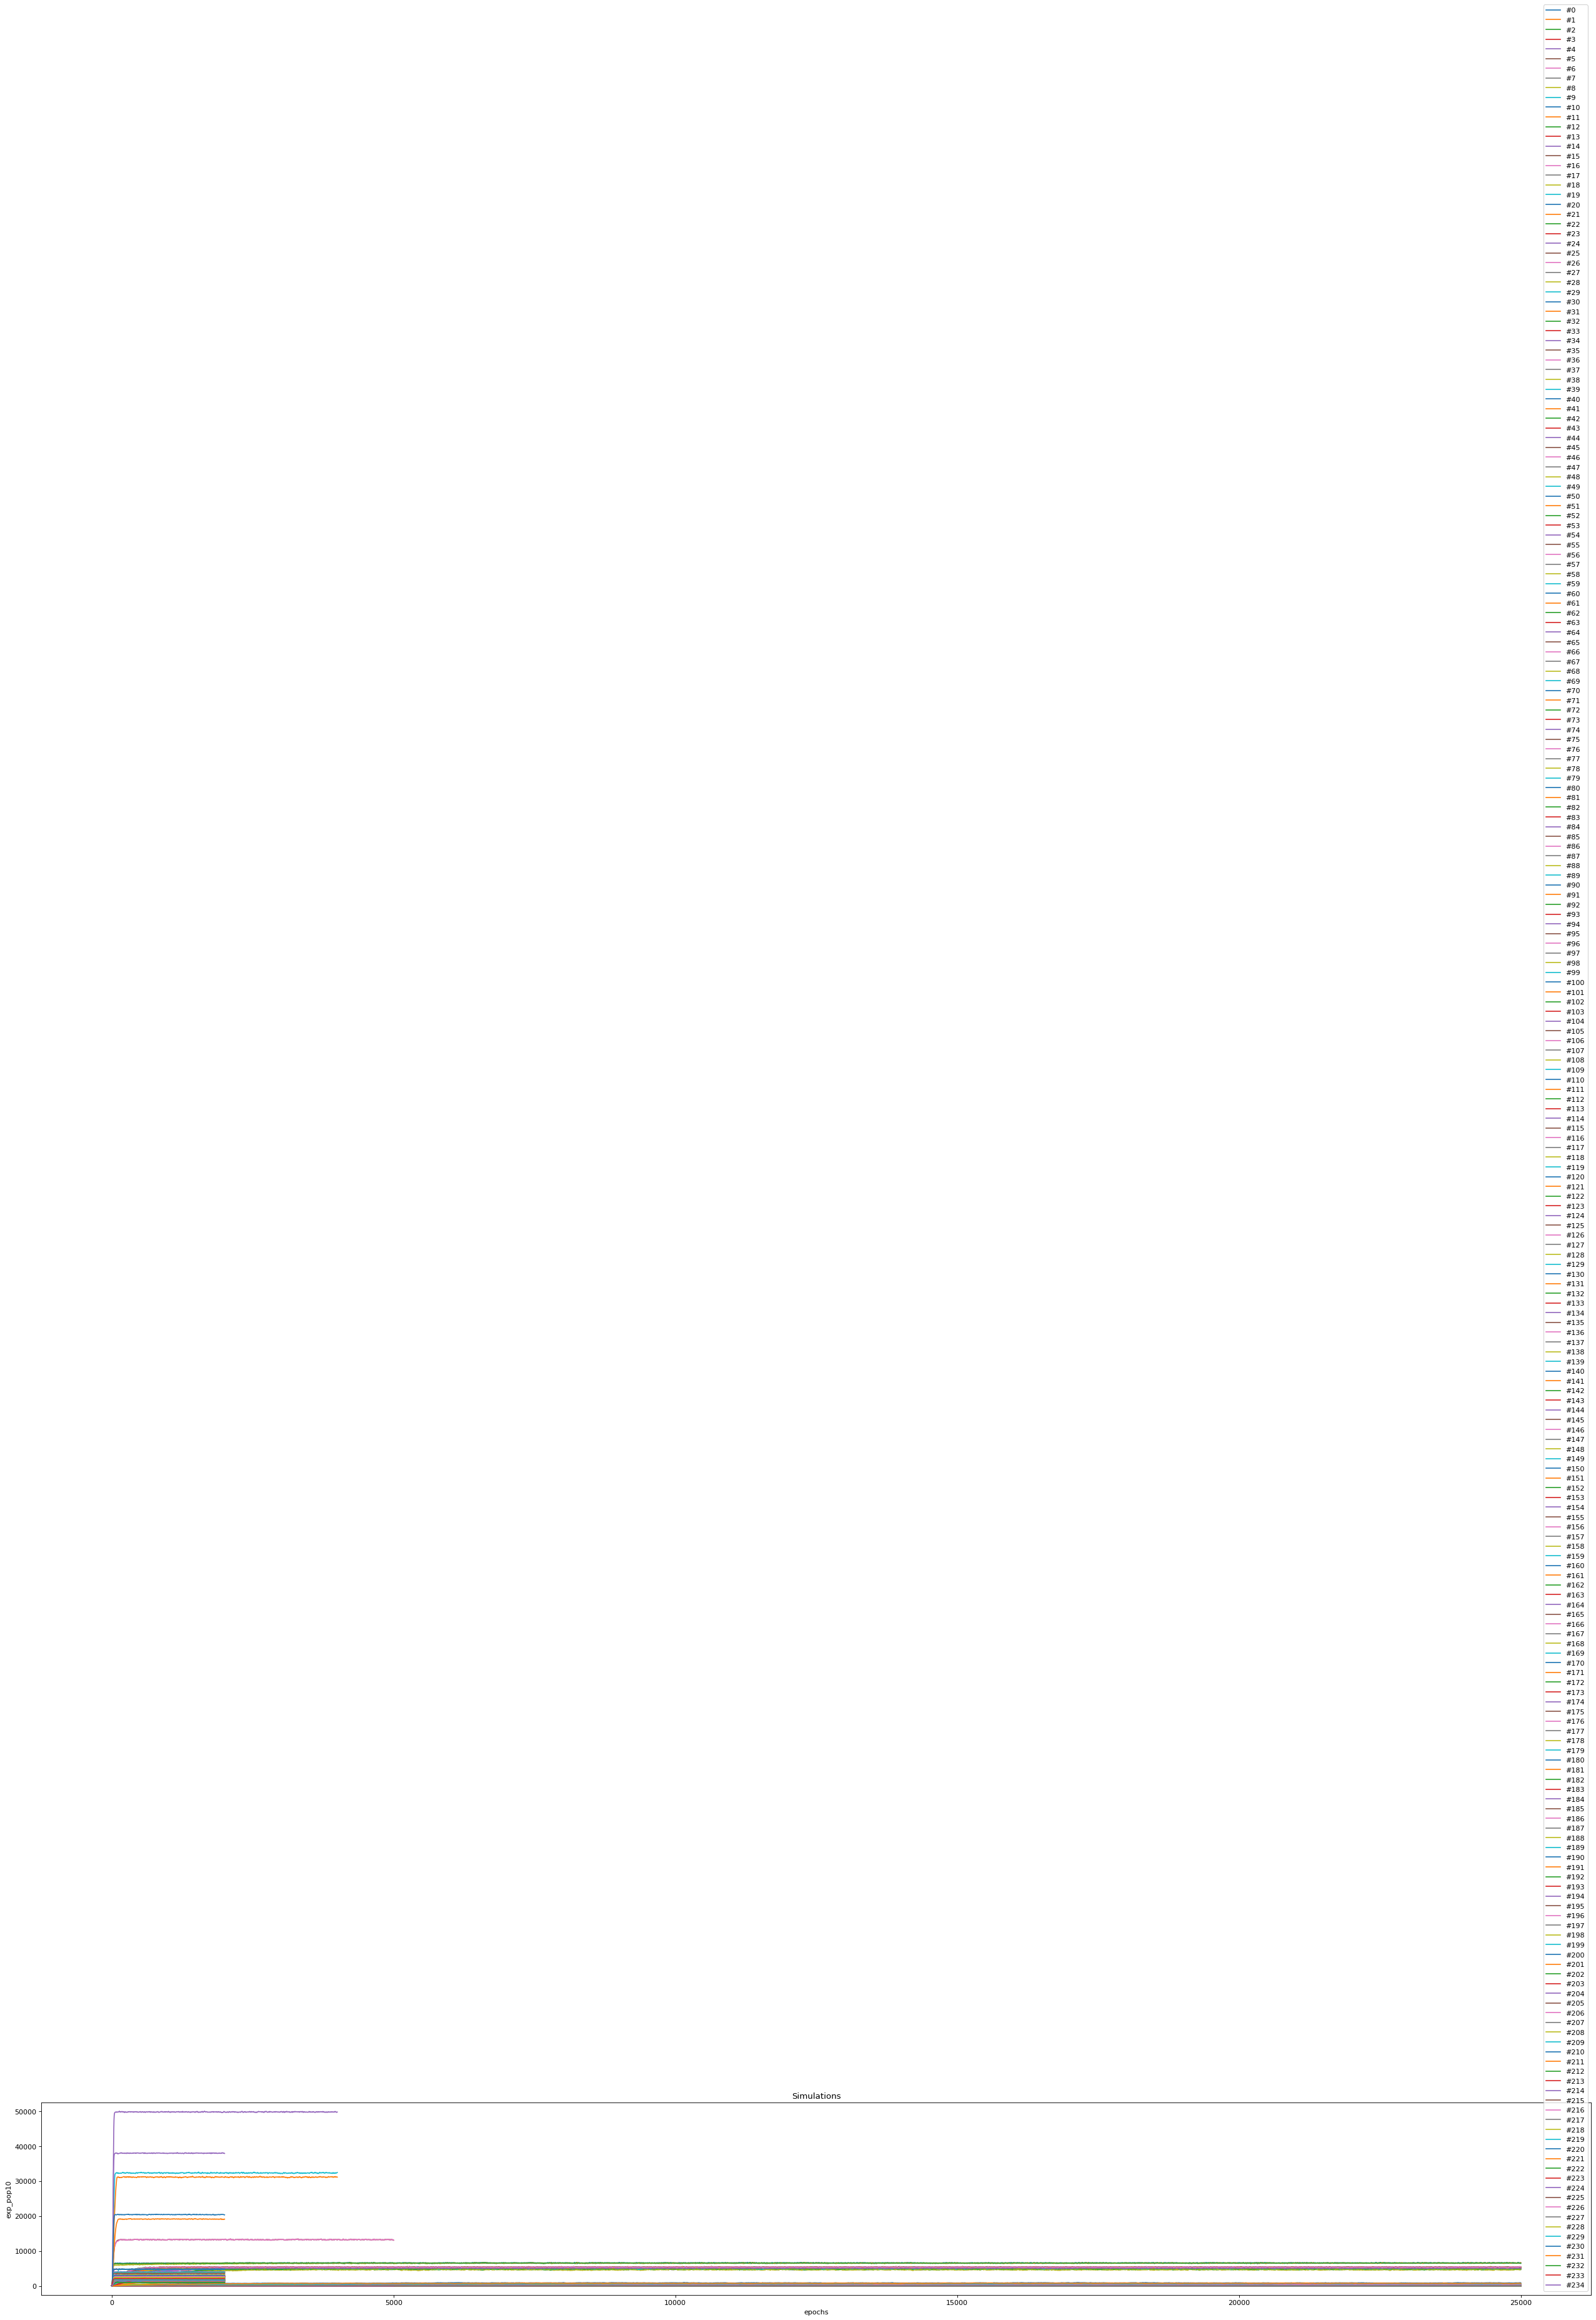

In [102]:
# построим все графики после 10 экспоненциального сглаживания
print_all_in_one_frame([data_ for data_ in data if not data_["params"]['auto_stop_at_plateau'] and not data_["params"]['realtime_limit_reached']] ,x = "epochs", y = "exp_pop10")

## Подбор окна сглаживания

       epochs                 time             exp_pop2
0           1                 0.00                 1.00
1           2                 1.59                 1.06
2           3                 1.96                 1.16
3           4                 2.41                 1.39
4           5                 3.43                 1.80
...       ...                  ...                  ...
24996   24997            15,461.75                 4.20
24997   24998            15,463.16                 3.94
24998   24999            15,463.86                 3.80
24999   25000            15,463.97                 3.98
25000   25001            15,464.35                 4.09

[25001 rows x 3 columns]


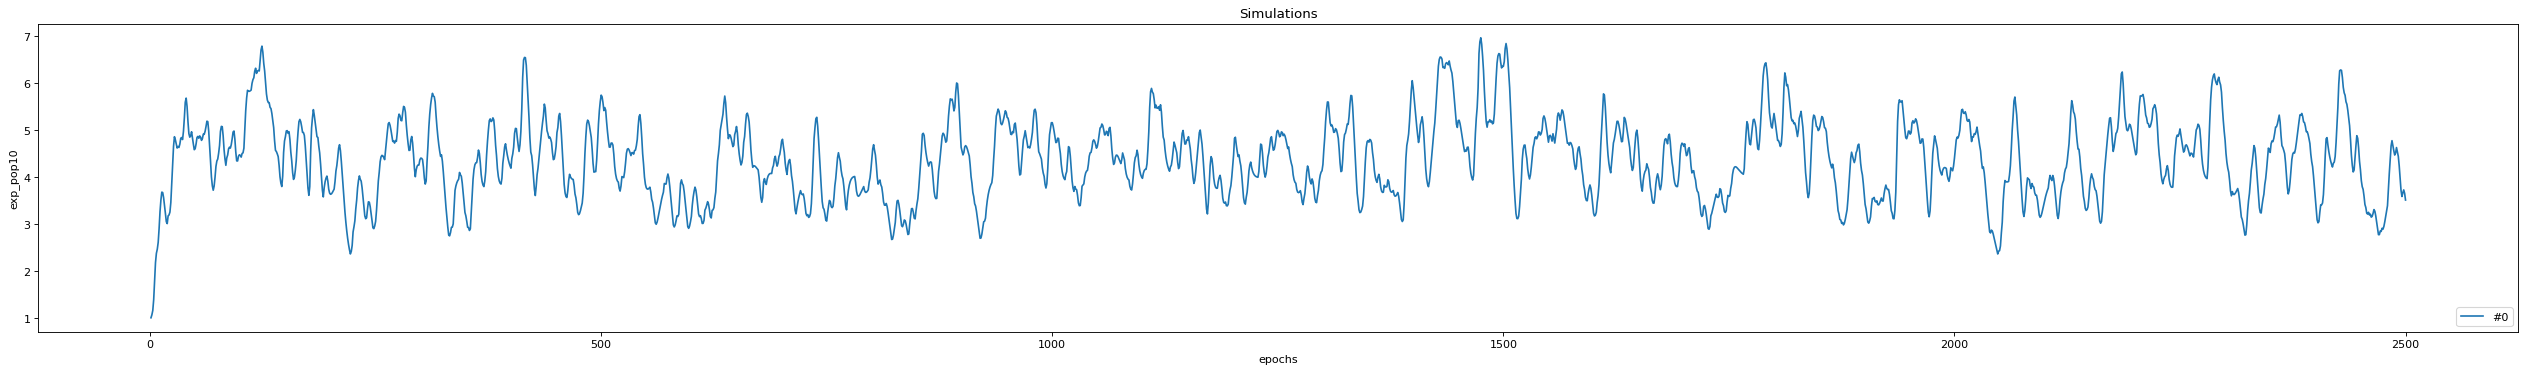

[0.9785718801566122, 0.7118761260231856, 0.6749038230730555, 0.5724439883801221, 0.5876786686722302, 0.5071594784527577, 0.47855310271818524, 0.24470358251911706, 0.8064465483625911, 0.564088755650694, 0.19353950641932208, 0.41614352780241887, 0.20343058870612338, 0.5809771725549122, 0.7241907380669632, 0.6260641202295064, 0.32775500127872076, 0.7675214315296499, 0.6126354869657732, 0.5475826015079032, 0.8336505519177405, 0.6282337647832149, 0.444066715216115, 0.45807822860537994, 0.8400660751062915, 0.6211948407313663, 0.7691510730308082, 0.5001335878689271, 0.9269511760658259, 0.5121301877563138, 0.4891013002566551, 0.8044361744074119, 0.3669684777634099, 0.2919004363563511, 0.3932513997459418, 0.5294403945204285, 0.4656020064650663, 0.520258067260606, 0.8279349874489503, 1.2004392854416697, 0.6643138708376918, 0.7123399254119568, 0.3437281665939145, 1.1049282112102212, 0.585685265695822, 0.6993845862587758, 0.5169528045014308, 0.23768726204798354, 0.5982973926846894, 0.2933101800072

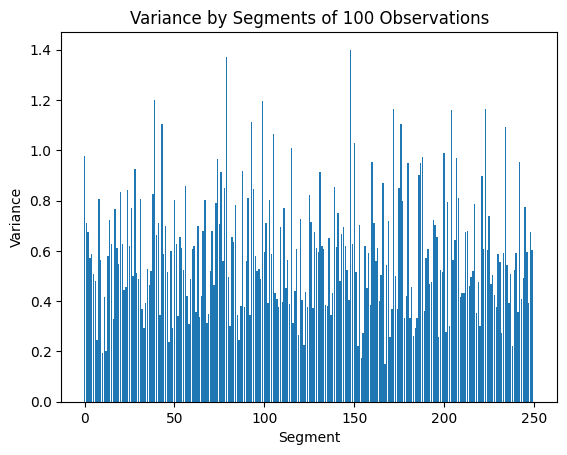

[0.9340950803911128, 0.6216765419885182, 0.5342145980594554, 0.3925391970404073, 0.789325565988269, 0.5963009042757441, 0.7129926399066839, 0.5952274978738622, 0.8355815618201785, 0.8076494848081736, 0.618422291363295, 0.498181875718589, 0.6875741214060069, 0.8690481269638894, 0.7772739637808858, 0.6845012026066584, 0.5673564620917951, 0.5557570287228596, 0.806744802909577, 0.48261032333485976, 0.5365435671245157, 0.5131728222186072, 0.6267658636723022, 0.5171230759035121, 0.7535025346368834, 0.7594620215577262, 0.936615252261909, 0.6812055540100576, 0.5431553497001448, 0.6046478223969458, 0.5747652521933495, 0.883709725690148, 0.6267511131150638, 0.9130468716850487, 0.6574313576434948, 0.6372451381862055, 0.5496610450918695, 0.6025159723415485, 0.6798812827146653, 0.486717063740921, 0.4848446459567769, 0.6165292425261933, 0.6053624587979133, 0.7610607186215618, 0.5632555462203566, 0.5027118826611562, 0.6396366130673402, 0.7060945148992429, 0.7353037753453596, 0.8264712376159757, 0.655

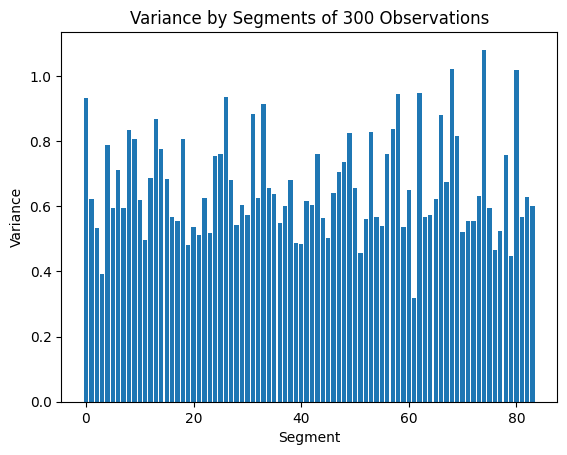

[0.8110611160252829, 0.562295999681346, 0.6152759006237803, 0.6061204120899363, 0.7310468953803985, 0.8255550435023175, 0.5325318583150359, 0.9368282519249667, 0.7605264499414806, 0.5949112406934075, 0.6218855892525681, 0.6510750355354173, 0.535695846479935, 0.5400370614699795, 0.7203690911277056, 0.900957259053248, 0.6755668175202106, 0.4917749896380996, 0.7613437065498925, 0.7906361136059088, 0.7063349711561808, 0.603129302145883, 0.6733507657101555, 0.5849494639104492, 0.4662432378326304, 0.7182672073165414, 0.67831599296125, 0.565888352505928, 0.7745813023491338, 0.7475397960311898, 0.5793317453938405, 0.68250761349191, 0.6990760948922237, 0.7036893190147221, 0.8223606361842907, 0.7242626528937085, 0.5204225977634749, 0.7077893575018318, 0.631177237916693, 0.7421970501683499, 0.8377044117333748, 0.867473727773425, 0.6158368250243995, 0.5792986066071794, 0.9100875385261327, 0.5298800254803437, 0.748619653875598, 0.5717798087255456, 0.824826641662625, 0.658439618235987, 0.0]
51


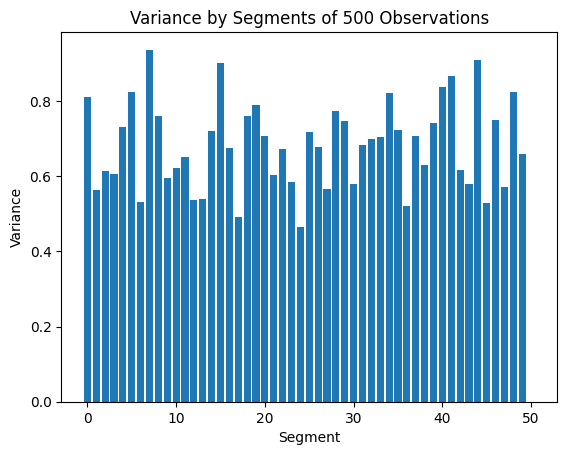

[0.7099567753104994, 0.6162657561709143, 0.7859075135052332, 0.7552816654246222, 0.7124230503417268, 0.637991394940286, 0.5507789246326666, 0.8118180672809556, 0.6035421107070692, 0.7845361561971931, 0.6549860747211438, 0.6298450703534614, 0.5931338702974791, 0.6222052487612791, 0.7684057054163215, 0.6310810715707619, 0.7016779587821361, 0.781023138443424, 0.6151588781612913, 0.709357249790214, 0.866519175932436, 0.613895510922735, 0.7487304607540255, 0.6641038069125638, 0.7416901847921312, 0.0]
26


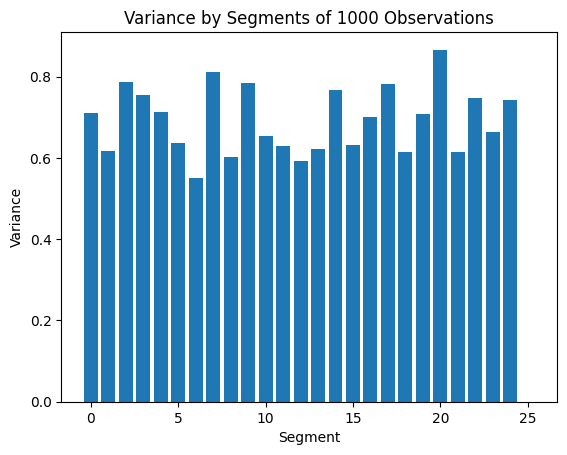

[0.6983511422910634, 0.7259894992051182, 0.7730831655679972, 0.6347458394178186, 0.6108198781633157, 0.7156192978750825, 0.7585009300833866, 0.6253798851000241, 0.6400438014841181, 0.7433697203688935, 0.660459092511481, 0.7578805752907829, 0.6252845019002116, 0.845734779131724, 0.7334132291071922, 0.624274305146865, 0.741202694604445]
17


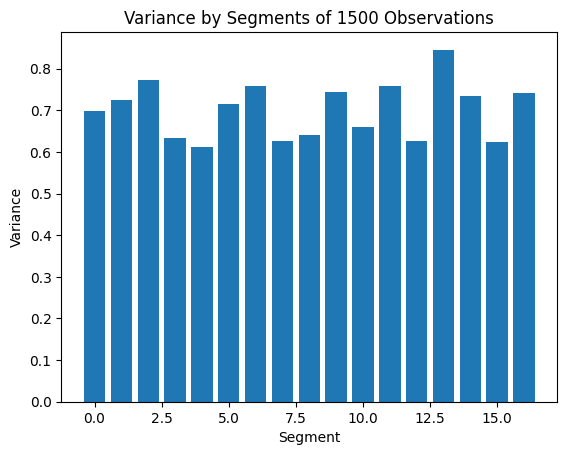

[0.6757723981790638, 0.7826818005675347, 0.6755559821360805, 0.6834012013741898, 0.7020065596818622, 0.6486003875342653, 0.6299910079831261, 0.7395421949004037, 0.7434535523519243, 0.6622616900294723, 0.7448567380805489, 0.7065261062076287, 0.741202694604445]
13


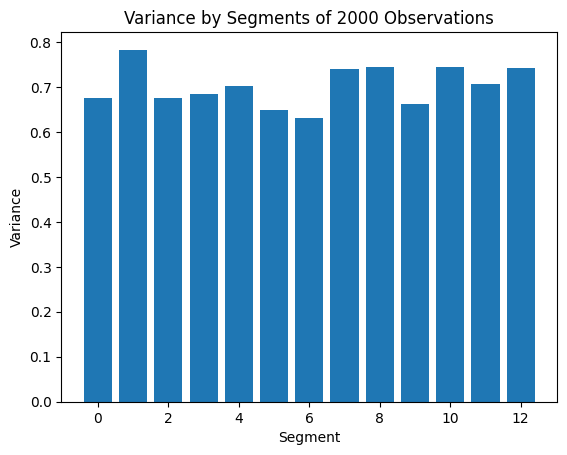

[0.7272862985943348, 0.686022468139923, 0.6760353461878384, 0.6939982976131216, 0.735743454777545, 0.0]
6


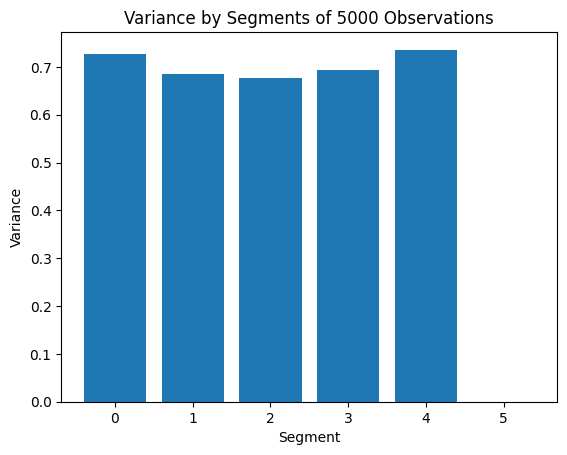

In [103]:
# пример для одной из симуляций
n = 3
print(data[n]["exp_pop10"])
print_all_in_one_frame([data[n]], x="epochs", y = "exp_pop10", limit = 2500)
plt.show()
for size in [100, 300, 500, 1000, 1500, 2000, 5000]:
  data_ = data[n]["exp_pop10"]["exp_pop2"]
  data_segments = [data_[i:i+size] for i in range(0, len(data_), size)]
  variances = [np.var(segment) for segment in data_segments]
  print(variances)
  print(len(variances))
  plt.bar(range(0, len(variances)), variances)
  # Добавляем заголовок и метки осей
  plt.title('Variance by Segments of ' + str(size) + ' Observations')
  plt.xlabel('Segment')
  plt.ylabel('Variance')
  plt.show()


## Подбор порога

In [104]:
max_arr = []
sec_mx_arr = []
for n in range(len(data)):
  for size in [max(500, len(data[n]["exp_pop10"])//5), max(1000, len(data[n]["exp_pop10"])//10)]:
    data_ = data[n]["exp_pop10"]["exp_pop2"]
    data_segments = [data_[i:i+size] for i in range(0, len(data_), size)]
    variances = [np.var(segment) or  0.00000001 for segment in data_segments]
    mx = -1
    sec_mx = -1
    for i in range(len(variances)-2):
      if (mx < variances[i]/variances[i+1] or mx < 1/(variances[i]/variances[i+1])):
        sec_mx = mx
      mx = max(variances[i]/variances[i+1], mx)
      # для убывающих графиков
      mx = max(1/(variances[i]/variances[i+1]), mx)
    max_arr.append(mx)
    if sec_mx!=-1:
      sec_mx_arr.append(sec_mx)

In [105]:
print(max_arr)
print(sec_mx_arr)

[1.1170106371127506, 1.198480557393127, 1.1785996985604081, 1.3725023685782682, 1.0570432818700344, 1.2733843391700193, 1.0601516708441479, 1.2244048244642523, 1.0609450347952738, 1.2614776279292048, 1.1307416763921143, 1.163079201087133, 1.1669689342376501, 1.1961858583996463, 1.062361113748831, 1.2827188118928627, 1.045749884228156, 1.2002982891773293, 1.1339530580699055, 1.401107540853252, 1.1092380119718344, 1.1245116276554272, 1.1056643284496879, 1.3120833388292836, 1.052219789606299, 1.3476845761275085, 1.06939406216702, 1.213381099792228, 1.0576793931118569, 1.1578352703331585, 1.0849267456062313, 1.325483638746708, 1.2339095602358578, 1.4354115082788175, 1.1214836945078592, 1.326520582760573, 1.0685279781706232, 1.3780932462655147, 1.0313739127123858, 1.2492319318579996, 1.171679973892085, 1.210184493833995, 1.1265630374672155, 1.2603461632244803, 1.1497072932659038, 1.2672688916528945, 1.1914391954579682, 1.2726761931533397, 1.1572431432058992, 1.1268698673991653, 4.1010064250

In [106]:
pd.DataFrame(max_arr).describe()

,0
count,470.00
mean,460.90
std,"1,653.77"
min,1.03
25%,2.63
50%,106.02
75%,360.42
max,"22,294.09"


In [107]:
pd.DataFrame(sec_mx_arr).describe()

,0
count,111.00
mean,1.89
std,2.53
min,1.01
25%,1.09
50%,1.26
75%,1.74
max,18.81
